İlk başta yapmamız gereken kategorik verileri kategorik haline çevirmek. (tür değişimi yap)
////
Daha sonra lazım olmayan besin değerini kaldırmak gerekli
////
tarih değerlerinin tarih tarih değil yıl yıl fiyatlarının ortalam ya da standart sapma şeklinde kategorik veriye çevir.
////
 Daha sonra nümerik değerlerdeki çıkarılabilecek herhanig bir değer var mı araşatır gerekirse IQR değerlerine bakarak min max değerleri belirle ve daha sonra aykırı değerleri çıkar.
////
Sonra dtamızdaki kategorik özellikler ve nümerik özellikleri bil liste halinde yaz
////
Daha sonra pipeline oluştur
////
Daha sonra test verisini ve eğitim verisini oluştur.
////
Sonra modeli oluştur (LinearRegression)
////
Daha sonra modeli fit ile kullan
////
Daha sonra modelin doğruluk değerlerine bak.

In [141]:
import pandas as pd # dataFrame haline çalışabilmek için, verileri daha iyi işleyebilmek için
import numpy as np # diziler üzerinde kullanılabilecek matematiksel ifadeler içeren kütüphane

from sklearn.model_selection import train_test_split # verileri ayırabilmek için

#model
from catboost import CatBoostRegressor, Pool

#modelin doğruluğunu ölçmek için
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt # grafik oluşturmak için

In [142]:
df = pd.read_csv('train.csv')

In [143]:
df.head() # verinin özelliklerini ve satırlarını görmüş olduk.

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir
0,2019-01-01,kıyma,120,et,32.70,Yurt içi,K,S
1,2019-01-01,tavuk,103,et,11.04,Yurt içi,K,S
2,2019-01-01,hindi,160,et,11.20,Yurt içi,K,S
3,2019-01-01,Bakla-kuru,354,sebze ve bakliyat,7.04,Yurt içi,K,S
4,2019-01-01,Bakla-taze,72,sebze ve bakliyat,13.28,Yurt içi,K,S


In [144]:
df.info() # eksik veri olmadığını ve bu verilerin türlerini görmüş olduk.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tarih              227520 non-null  object 
 1   ürün               227520 non-null  object 
 2   ürün besin değeri  227520 non-null  int64  
 3   ürün kategorisi    227520 non-null  object 
 4   ürün fiyatı        227520 non-null  float64
 5   ürün üretim yeri   227520 non-null  object 
 6   market             227520 non-null  object 
 7   şehir              227520 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.9+ MB


In [145]:
df.describe() # verilerin matematiksel hesaplarını görmüş olduk.

,ürün besin değeri,ürün fiyatı
count,227520.000000,227520.000000
mean,143.113924,17.018837
std,133.218871,14.470524
min,8.000000,0.740000
25%,41.000000,7.380000
50%,83.000000,12.860000
75%,250.000000,21.630000
max,402.000000,164.530000


In [146]:
df.isnull().sum # burada ise bütün colonları tek tek eksik veri var mı diye sorguladık ama eksik veri olmadığından bğtğn değerler gördüğümüz gibi False çıktı.

<bound method DataFrame.sum of         tarih   ürün  ürün besin değeri  ürün kategorisi  ürün fiyatı  \
0       False  False              False            False        False   
1       False  False              False            False        False   
2       False  False              False            False        False   
3       False  False              False            False        False   
4       False  False              False            False        False   
...       ...    ...                ...              ...          ...   
227515  False  False              False            False        False   
227516  False  False              False            False        False   
227517  False  False              False            False        False   
227518  False  False              False            False        False   
227519  False  False              False            False        False   

        ürün üretim yeri  market  şehir  
0                  False   False  False  
1       

In [147]:
cat_features = ['ürün', 'market', 'şehir', 'ürün kategorisi', 'ürün üretim yeri']
# bütün kategorik değerler eklendi

In [148]:
# bunların içerisine tarih verisi de eklenebilir.

Tarih verilerini DateTime'e çevirme

In [149]:
# tarih kolonu DateTime formatına çevrildi.
df['tarih'] = pd.to_datetime(df['tarih'])

# yıl ay gün olarak yeni sütunlar oluşturma:
df['yıl'] = df['tarih'].dt.year
df['ay'] = df['tarih'].dt.month
df['gün'] = df['tarih'].dt.day
df['hafta_günü'] = df['tarih'].dt.dayofweek

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   tarih              227520 non-null  datetime64[ns]
 1   ürün               227520 non-null  object        
 2   ürün besin değeri  227520 non-null  int64         
 3   ürün kategorisi    227520 non-null  object        
 4   ürün fiyatı        227520 non-null  float64       
 5   ürün üretim yeri   227520 non-null  object        
 6   market             227520 non-null  object        
 7   şehir              227520 non-null  object        
 8   yıl                227520 non-null  int32         
 9   ay                 227520 non-null  int32         
 10  gün                227520 non-null  int32         
 11  hafta_günü         227520 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(5)
memory usage: 17.4+ MB


In [151]:
# Şehir ve ürün bazında ortalama fiyat
df['şehir_ürün_ortalama_fiyat'] = df.groupby(['şehir', 'ürün'])['ürün fiyatı'].transform('mean')

In [152]:
df['önceki fiyat'] = df.groupby('ürün')['ürün fiyatı'].shift(1)

Veri setini eğitim ve test olarak bölme

In [153]:
# model eğiteceğimiz için X matrisi için yaptığımız şey fiyatın olduğu yeri kaldırmak.
X = df.drop(columns=['ürün fiyatı'])
# buradaki amaç ise y vektörüne ürünlerin fiyatlarını atamak
y = df['ürün fiyatı'] 

# verileri eğitim ve test olarak ayırma

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# catboost modeli için kategorik sütunların indeksleri

cat_features_indices = [X.columns.get_loc(col) for col in cat_features]

In [155]:
X_train = X_train.drop(columns=['tarih'])
X_test = X_test.drop(columns=['tarih'])

In [156]:
cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features]


In [157]:
#catboost modeli pool objesi oluştur. Bu format hızlı ve uygun
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
test_pool = Pool(X_test,y_test, cat_features=cat_features_indices)

In [158]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100
)

In [159]:
model.fit(train_pool, eval_set=test_pool)

0:	learn: 13.8151205	test: 13.7204194	best: 13.7204194 (0)	total: 96.7ms	remaining: 1m 36s
100:	learn: 1.9027072	test: 1.9076603	best: 1.9076603 (100)	total: 10.9s	remaining: 1m 36s


KeyboardInterrupt: 

In [ ]:
# Test verisi üzerinde tahmin yap
y_pred = model.predict(test_pool)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"✅ MAE  (Mean Absolute Error):     {mae:.3f}")
print(f"✅ R²   (R-squared):                {r2:.3f}")


✅ RMSE (Root Mean Squared Error): 1.366
✅ MAE  (Mean Absolute Error):     0.828
✅ R²   (R-squared):                0.991


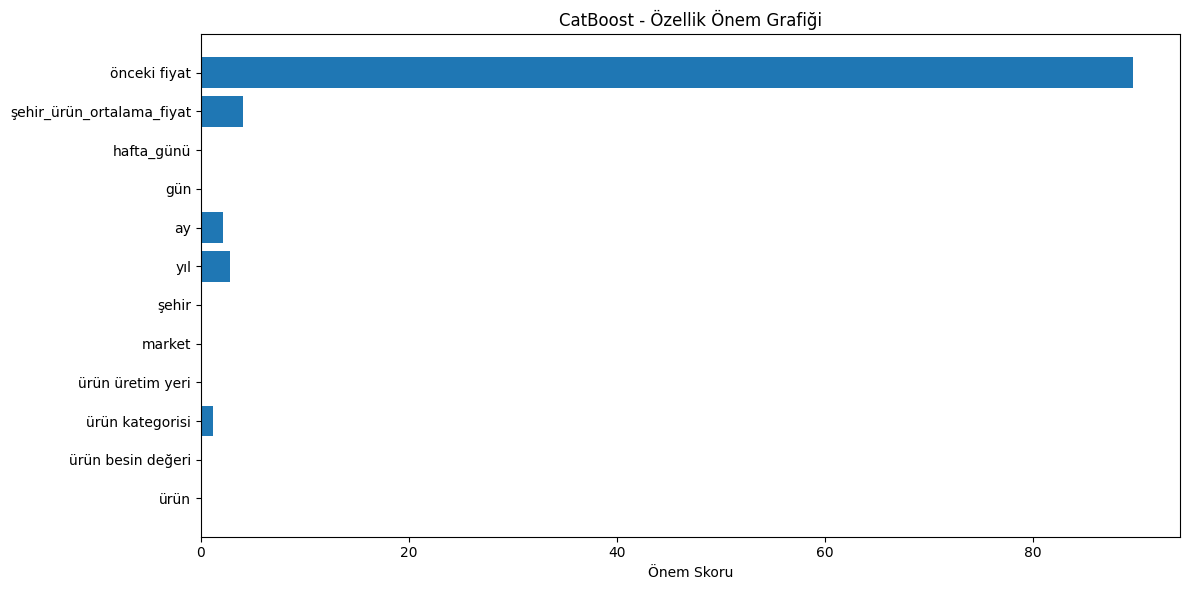

In [ ]:
# grafşkleştirme

feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Önem Skoru")
plt.title("CatBoost - Özellik Önem Grafiği")
plt.tight_layout()
plt.show()

In [ ]:
# Modeli diske kaydet
model.save_model("catboost_model.cbm")

# Yeniden yüklemek istersen:
# from catboost import CatBoostRegressor
# model = CatBoostRegressor()
# model.load_model("catboost_model.cbm")
